In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from gplearn.genetic import SymbolicTransformer
from sklearn.datasets import load_breast_cancer
from gplearn.genetic import SymbolicClassifier
from sklearn.metrics import roc_auc_score

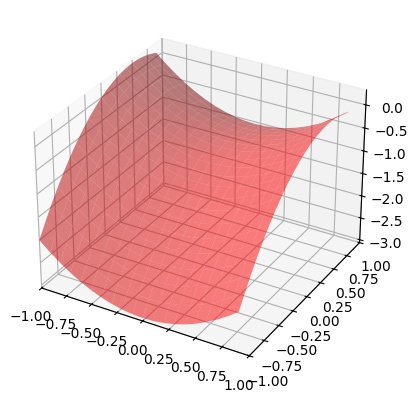

In [2]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='red', alpha=0.5)
plt.show()

In [3]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

In [4]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           max_samples=0.9,
                           verbose=1,
                           parsimony_coefficient=0.01,
                           random_state=0)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764     43.92s
   1     9.97          1.70233        5         0.320202         0.624787     26.58s
   2     7.72          1.94456       11         0.239537         0.533148     23.12s
   3     5.41         0.990157        7         0.235676         0.719906     21.01s
   4     4.66         0.894443       11         0.103946         0.103946     20.20s
   5     5.41         0.940242       11         0.060802         0.060802     18.39s
   6     6.78          1.09536       11      0.000781474      0.000781474     17.07s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [5]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


In [6]:
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor()

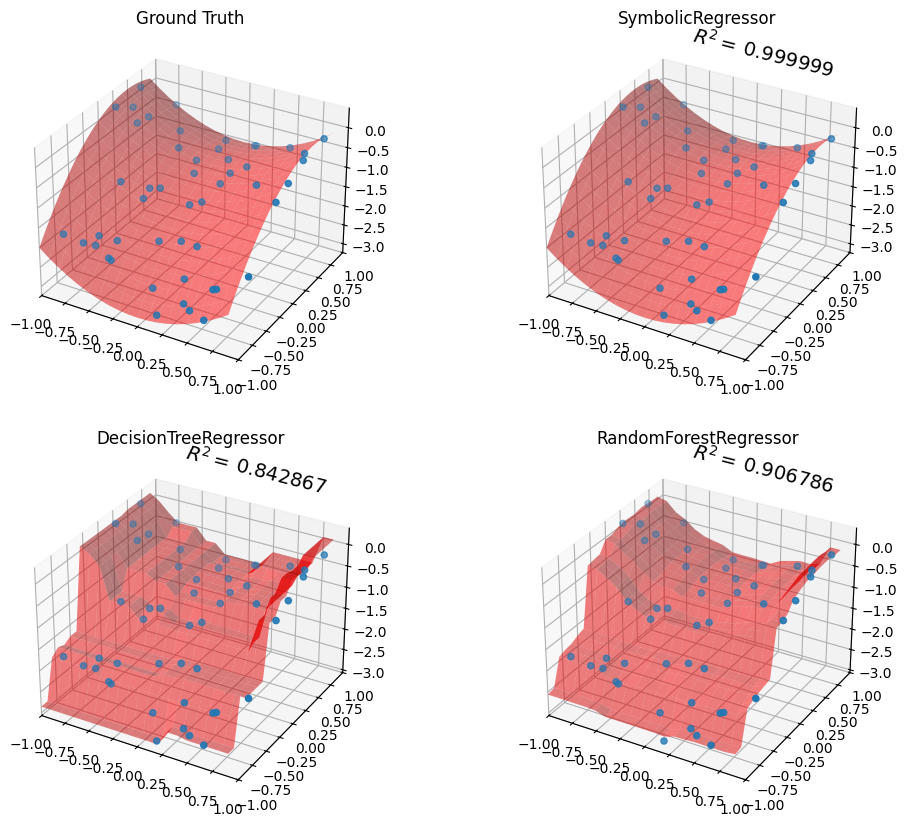

In [7]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='red', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)
plt.show()

In [8]:
print(est_gp._program.parents)

{'method': 'Crossover', 'parent_idx': 1555, 'parent_nodes': range(1, 4), 'donor_idx': 78, 'donor_nodes': []}


In [9]:
idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)

In [10]:
rng = check_random_state(0)
diabetes = load_diabetes()
perm = rng.permutation(diabetes.target.size)
diabetes.data = diabetes.data[perm]
diabetes.target = diabetes.target[perm]

In [11]:
est = Ridge()
est.fit(diabetes.data[:300, :], diabetes.target[:300])
print(est.score(diabetes.data[300:, :], diabetes.target[300:]))

0.43405742105789413


In [12]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
gp = SymbolicTransformer(generations=20,
                         population_size=2000,
                         hall_of_fame=100,
                         n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         verbose=1,
                         random_state=0,
                         n_jobs=3)

gp.fit(diabetes.data[:300, :], diabetes.target[:300])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.37         0.126618        5         0.612827             0.68     17.09s
   1     6.63         0.344375        3         0.659086         0.451797      8.36s
   2     5.36         0.473731        3         0.669019         0.321485      8.34s
   3     4.74         0.587613        3         0.673354          0.31249      7.11s
   4     4.39         0.597151       13         0.675282          0.49482      6.95s
   5     4.31         0.611995       15         0.686134         0.148203      6.44s
   6     4.89         0.611891        9         0.685649         0.199002      6.21s
   7     6.49         0.617031        9         0.688309         0.287286      5.59s
   8     9.19         0.628618       17         0.720606          0.26362  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    max_samples=0.9, n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=2000, random_state=0, verbose=1)

In [13]:
gp_features = gp.transform(diabetes.data)
new_diabetes = np.hstack((diabetes.data, gp_features))

In [14]:
est = Ridge()
est.fit(new_diabetes[:300, :], diabetes.target[:300])
print(est.score(new_diabetes[300:, :], diabetes.target[300:]))

0.5336788517320443


In [15]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

In [16]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

In [17]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)

0.9693786982248521

In [18]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)